In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


In [2]:
import tensorflow_addons as tfa

In [3]:
import wispy.mscalev4

In [4]:
def make_data(N=50):
    x = np.random.uniform(size=N)

    # y = 2 * np.sin(3.9*x) + 3 * np.sin(16*x)
    y = 2 * np.sin(3.9*x) + 3 * np.sin(16*x)
    

    return x.reshape(-1, 1), y.reshape(-1, 1)
    # return x.reshape(1, -1), y.reshape(1, -1)

In [5]:
x, y = make_data(N=500)
xval, yval = make_data(N=100)

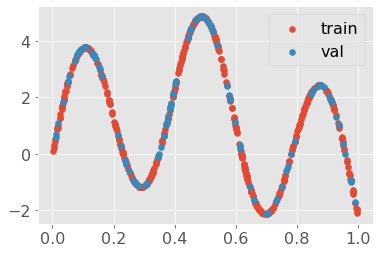

In [6]:
plt.figure()
plt.scatter(x, y, label='train')
plt.scatter(xval, yval, label='val')
plt.legend()

In [7]:
from tensorflow.keras.utils import get_custom_objects
import pugna.activations
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [90]:
model = wispy.mscalev4.build_model(
    input_shape=x.shape[1],
    output_shape=y.shape[1],
    units=128,
    scales=[1,10],
    n_blocks=5,
    layers_per_block=5,
    scale_activation='s2relu',
    dtype='float32'
)
model.compile(loss='mse', optimizer='adam')

In [91]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
scale_layer_14 (ScaleLayer)     (None, 1)            0           input_10[0][0]                   
__________________________________________________________________________________________________
scale_layer_15 (ScaleLayer)     (None, 1)            0           input_10[0][0]                   
__________________________________________________________________________________________________
dense_686 (Dense)               (None, 128)          256         scale_layer_14[0][0]             
____________________________________________________________________________________________

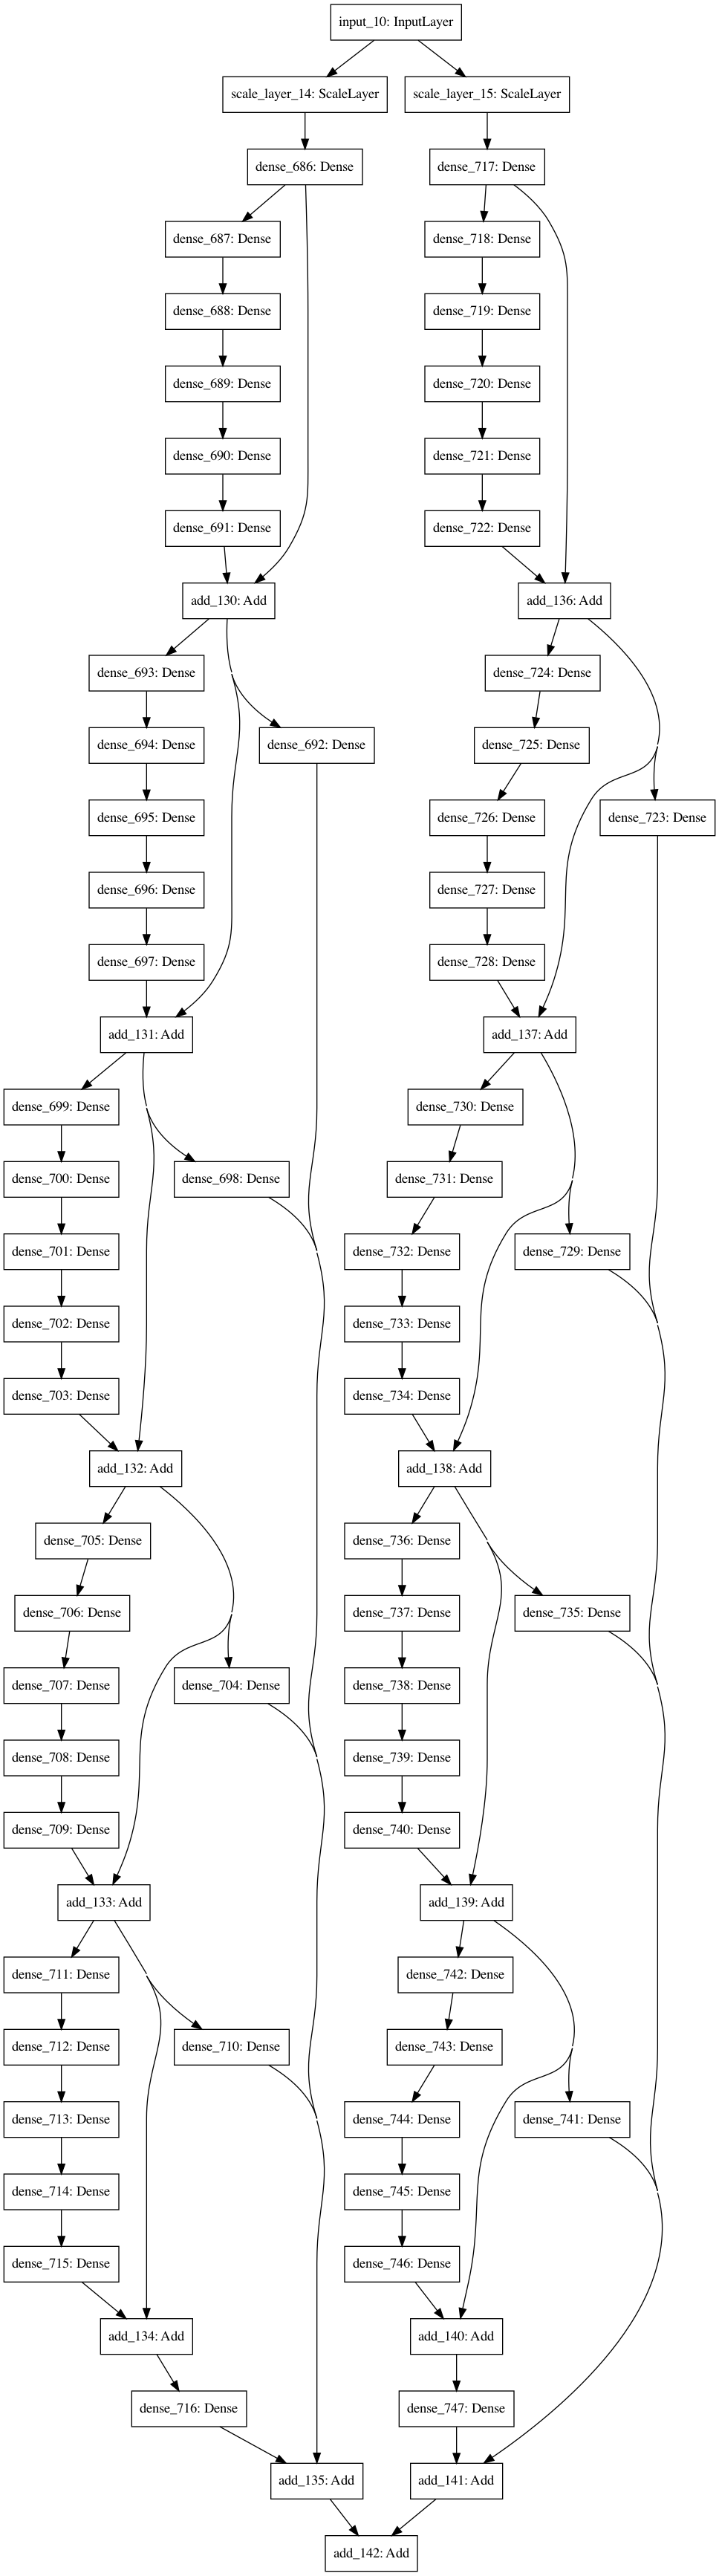

In [92]:
tf.keras.utils.plot_model(model)

In [93]:
%%time
callbacks = []
callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=300, min_lr=1e-5))

tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history = model.fit(x, y, validation_data=(xval, yval), epochs=2000, batch_size=500, verbose=0, callbacks=callbacks)

Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

CPU times: user 4min 6s, sys: 54.5 s, total: 5min 1s
Wall time: 1min 49s


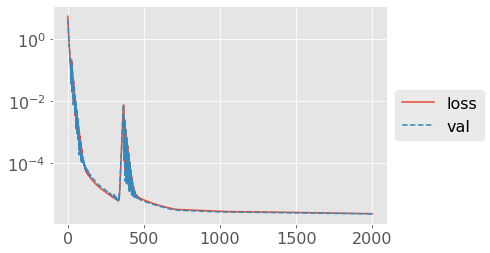

In [94]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val', ls='--')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

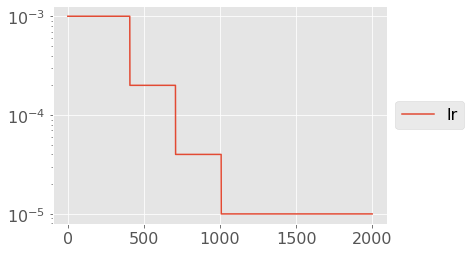

In [95]:
plt.figure()
plt.plot(history.history['lr'], label='lr')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

Text(0.5, 1.0, 'training')

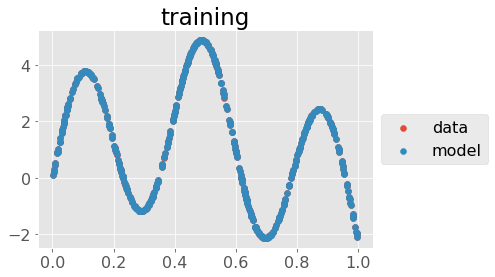

In [96]:
plt.figure()
plt.scatter(x, y, label='data')
plt.scatter(x, model.predict(x), label='model')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('training')

Text(0.5, 1.0, 'training')

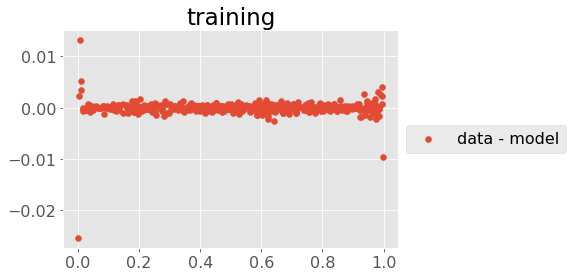

In [97]:
plt.figure()
plt.scatter(x, y-model.predict(x), label='data - model')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('training')

Text(0.5, 1.0, 'validation')

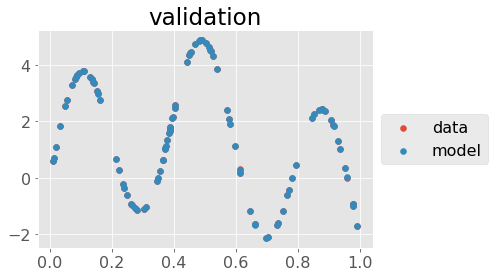

In [98]:
plt.figure()
plt.scatter(xval, yval, label='data')
plt.scatter(xval, model.predict(xval), label='model')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('validation')

Text(0.5, 1.0, 'validation')

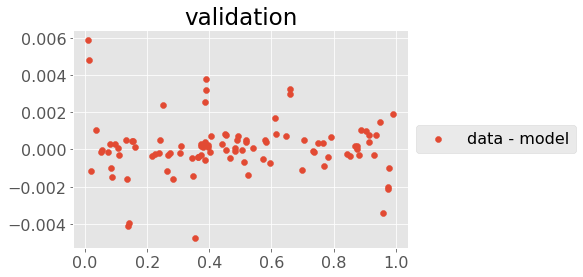

In [99]:
plt.figure()
plt.scatter(xval, yval-model.predict(xval), label='data - model')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('validation')

# comparison to a 'plain' network

In [23]:
def build_base_model(input_shape, output_shape, width, depth):
    inputs = keras.Input(shape=(input_shape,))

    x = layers.Dense(width, 'relu')(inputs)
    for i in range(depth):
        x = layers.Dense(width, 'relu')(x)

    outputs = layers.Dense(output_shape)(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name=f"base_model")

    return model

In [25]:
model_base = build_base_model(input_shape=x.shape[1], output_shape=y.shape[1], width=int(128), depth=19)
model_base.compile(loss='mse', optimizer='adam')

In [26]:
model_base.summary()

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_205 (Dense)            (None, 128)               256       
_________________________________________________________________
dense_206 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_207 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_208 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_209 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_210 (Dense)            (None, 128)               1

In [27]:
%%time
callbacks = []
callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=1e-5))

tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_base = model_base.fit(x, y, validation_data=(xval, yval), epochs=2000, batch_size=500, validation_batch_size=100, verbose=0, callbacks=callbacks)

Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

CPU times: user 2min 10s, sys: 20.4 s, total: 2min 30s
Wall time: 1min 19s


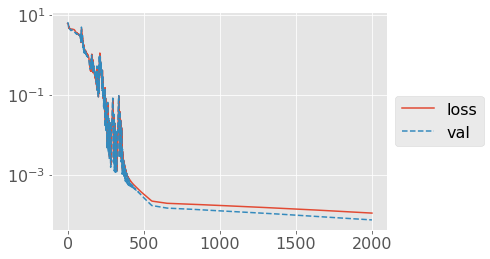

In [28]:
plt.figure()
plt.plot(history_base.history['loss'], label='loss')
plt.plot(history_base.history['val_loss'], label='val', ls='--')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

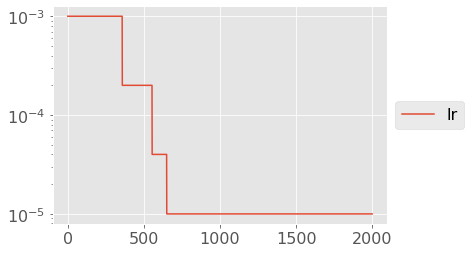

In [29]:
plt.figure()
plt.plot(history_base.history['lr'], label='lr')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

Text(0.5, 1.0, 'training')

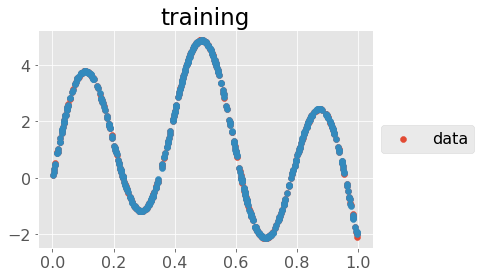

In [30]:
plt.figure()
plt.scatter(x, y, label='data')
plt.scatter(x, model_base.predict(x))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('training')

Text(0.5, 1.0, 'training')

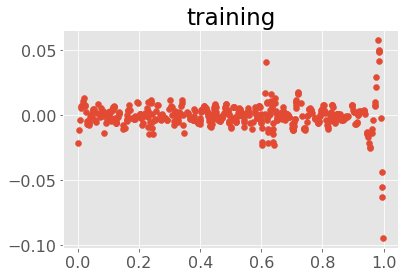

In [31]:
plt.figure()
plt.scatter(x, y-model_base.predict(x))
plt.title('training')

Text(0.5, 1.0, 'validation')

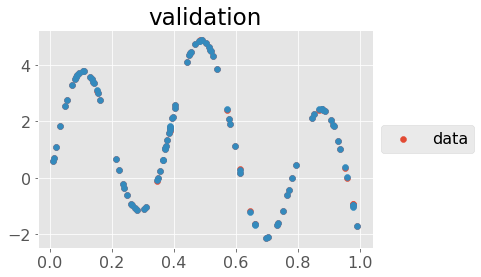

In [32]:
plt.figure()
plt.scatter(xval, yval, label='data')
plt.scatter(xval, model_base.predict(xval))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('validation')

Text(0.5, 1.0, 'validation')

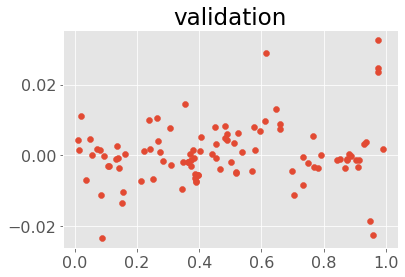

In [33]:
plt.figure()
plt.scatter(xval, yval-model_base.predict(xval))
plt.title('validation')

# comparison

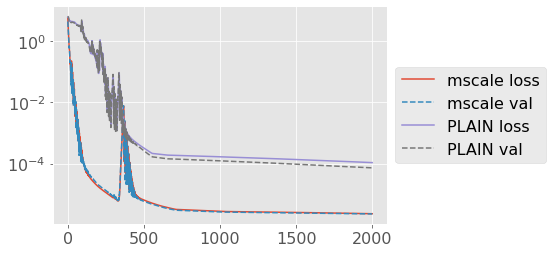

In [100]:
plt.figure()

plt.plot(history.history['loss'], label='mscale loss')
plt.plot(history.history['val_loss'], label='mscale val', ls='--')

plt.plot(history_base.history['loss'], label='PLAIN loss')
plt.plot(history_base.history['val_loss'], label='PLAIN val', ls='--')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

In [101]:
plt.figure()
plt.scatter(x, np.abs(y-model.predict(x)), label='mscale')
plt.scatter(x, np.abs(y-model_base.predict(x)), label='PLAIN')
plt.title('training')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

In [102]:
plt.figure()
plt.plot(xval, np.abs(yval-model.predict(xval)), 'o', label='RESNET')
plt.plot(xval, np.abs(yval-model_base.predict(xval)), 'o', label='PLAIN')
plt.title('test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')